In [1]:
using Plots, PlutoUI
using StatsPlots
using GenesInteraction
using MLJ
using Distributions
using StableRNGs
using StatsBase
using CategoricalArrays
using Tables
using MLJFlux: Short

# Environment initialisation

Loading some models

In [2]:
LogisticClassifier = @load LogisticClassifier pkg=MLJLinearModels verbosity=0
LinearRegressor = @load LinearRegressor pkg=MLJLinearModels verbosity=0
EvoTreeRegressor = @load EvoTreeRegressor pkg=EvoTrees verbosity=0
DecisionTreeRegressor = @load DecisionTreeRegressor pkg=DecisionTree verbosity=0
NeuralNetworkRegressor = @load NeuralNetworkRegressor pkg=MLJFlux verbosity=0
NuSVR = @load NuSVR pkg=LIBSVM verbosity=0
KNNRegressor = @load KNNRegressor pkg=NearestNeighborModels verbosity=0
DecisionTreeClassifier = @load DecisionTreeClassifier pkg=DecisionTree verbosity=0
KNNClassifier = @load KNNClassifier pkg=NearestNeighborModels verbosity=0

NearestNeighborModels.KNNClassifier

In [3]:
expit(x) = 1 ./ (1 .+ exp.(-x))

expit (generic function with 1 method)

# Simulation Datasets

## Continuous problems

In [4]:
function continuous_problem(rng;n=100)
    Unif = Uniform(0, 1)
    W = float(rand(rng, Bernoulli(0.5), n, 3))
    t = rand(rng, Unif, n) .< expit(0.5W[:, 1] + 1.5W[:, 2] - W[:,3])
    y = t + 2W[:, 1] + 3W[:, 2] - 4W[:, 3] + rand(rng, Normal(0,1), n)
    # Type coercion
    W = MLJ.table(W)
    t = categorical(t)
    return t, W, y, 1
end

function interaction_continuous_problem(rng;n=100)
    μy_fn(W, T₁, T₂) = 2W[:, 1] .+ 1W[:, 2] .- 2W[:, 3] .- T₁ .+ T₂ .+ 2*T₁ .* T₂
    # Sampling W: Bernoulli
    W = rand(rng, Bernoulli(0.5), n, 3)

    # Sampling T₁, T₂ from W: Softmax
    θ = [1 2 -3 -2; 
         -2 4 6 0 ;
         3 -1 -4 2]
    softmax = exp.(W*θ) ./ sum(exp.(W*θ), dims=2)
    T = [sample(rng, [1, 2, 3, 4], Weights(softmax[i, :])) for i in 1:n]
    T₁ = [t in (1,2) ? true : false for t in T]
    T₂ = [t in (1,3) ? true : false for t in T]

    # Sampling y from T₁, T₂, W: Logistic
    μy = μy_fn(W, T₁, T₂)
    y = μy + rand(Normal(0, 0.1), n)

    # Respect the Tables.jl interface and convert types
    W = MLJ.table(float(W))
    T = (T₁ = categorical(T₁), T₂ = categorical(T₂))

    # Compute the theoretical ATE
    Wcomb = [1 1 1;
            1 1 0;
            1 0 0;
            1 0 1;
            0 1 0;
            0 0 0;
            0 0 1;
            0 1 1]
    ATE = 0
    for i in 1:8
        w = reshape(Wcomb[i, :], 1, 3)
        temp = μy_fn(w, [1], [1])[1]
        temp += μy_fn(w, [0], [0])[1]
        temp -= μy_fn(w, [1], [0])[1]
        temp -= μy_fn(w, [0], [1])[1]
        ATE += temp*0.5*0.5*0.5
    end
    return T, W, y, ATE
end

interaction_continuous_problem (generic function with 1 method)

## Categorical problems

In [5]:
function categorical_problem(rng;n=100)
    p_w() = 0.3
    pa_given_w(w) = 1 ./ (1 .+ exp.(-0.5w .+ 1))
    py_given_aw(a, w) = 1 ./ (1 .+ exp.(2w .- 3a .+ 1))
    # Sample from dataset
    Unif = Uniform(0, 1)
    w = rand(rng, Unif, n) .< p_w()
    t = rand(rng, Unif, n) .< pa_given_w(w)
    y = rand(rng, Unif, n) .< py_given_aw(t, w)
    # Convert to dataframe to respect the Tables.jl
    # and convert types
    W = (W=convert(Array{Float64}, w),)
    t = categorical(t)
    y = categorical(y)
    # Compute the theoretical ATE
    ATE₁ = py_given_aw(1, 1)*p_w() + (1-p_w())*py_given_aw(1, 0)
    ATE₀ = py_given_aw(0, 1)*p_w() + (1-p_w())*py_given_aw(0, 0)
    ATE = ATE₁ - ATE₀
    
    return t, W, y, ATE
end

function interaction_categorical_problem(rng;n=100)
    μy_fn(W, T₁, T₂) = expit(2W[:, 1] .+ 1W[:, 2] .- 2W[:, 3] .- T₁ .+ T₂ .+ 2*T₁ .* T₂)
    # Sampling W: Bernoulli
    W = rand(rng, Bernoulli(0.5), n, 3)

    # Sampling T₁, T₂ from W: Softmax
    θ = [1 2 -3 -2; 
         -2 4 6 0 ;
         3 -1 -4 2]
    softmax = exp.(W*θ) ./ sum(exp.(W*θ), dims=2)
    T = [sample(rng, [1, 2, 3, 4], Weights(softmax[i, :])) for i in 1:n]
    T₁ = [t in (1,2) ? true : false for t in T]
    T₂ = [t in (1,3) ? true : false for t in T]

    # Sampling y from T₁, T₂, W: Logistic
    μy = μy_fn(W, T₁, T₂)
    y = [rand(rng, Bernoulli(μy[i])) for i in 1:n]

    # Respect the Tables.jl interface and convert types
    W = MLJ.table(float(W))
    T = (T₁ = categorical(T₁), T₂ = categorical(T₂))
    y = categorical(y)

    # Compute the theoretical ATE
    Wcomb = [1 1 1;
            1 1 0;
            1 0 0;
            1 0 1;
            0 1 0;
            0 0 0;
            0 0 1;
            0 1 1]
    ATE = 0
    for i in 1:8
        w = reshape(Wcomb[i, :], 1, 3)
        temp = μy_fn(w, [1], [1])[1]
        temp += μy_fn(w, [0], [0])[1]
        temp -= μy_fn(w, [1], [0])[1]
        temp -= μy_fn(w, [0], [1])[1]
        ATE += temp*0.5*0.5*0.5
    end
    return T, W, y, ATE
end


interaction_categorical_problem (generic function with 1 method)

# Advantage of using the Stack

In [6]:
n = 10000
p = 3
rng = StableRNG(123)
X = rand(rng, n, p)
y = 3exp.(-X[:, 1].*X[:, 2]) .+ sin.(X[:,2] .- X[:, 3]) .- log.(X[:, 3]) + rand(Normal(0, 0.1), n);

In [7]:
library = (LinearRegression=LinearRegressor(),
            DecisionTree=DecisionTreeRegressor(),
            Nnet=NeuralNetworkRegressor(builder=Short(n_hidden=2)),
            KNN=KNNRegressor(),
            NuSVM=NuSVR());

In [8]:
stack = Stack(;metalearner=LinearRegressor(), 
            resampling=CV(;nfolds=5), 
            library...);

In [9]:
all_models = (TheStack=stack, library...)
Xtable = MLJ.table(X)
measurements = []
modelnames = []
for (modelname, model) in zip(keys(all_models), all_models)
    mach = machine(model, Xtable, y)
    res = evaluate!(mach; resampling=Holdout(), measure=rmse)
    push!(measurements, res.measurement[1])
    push!(modelnames, string(modelname))
end

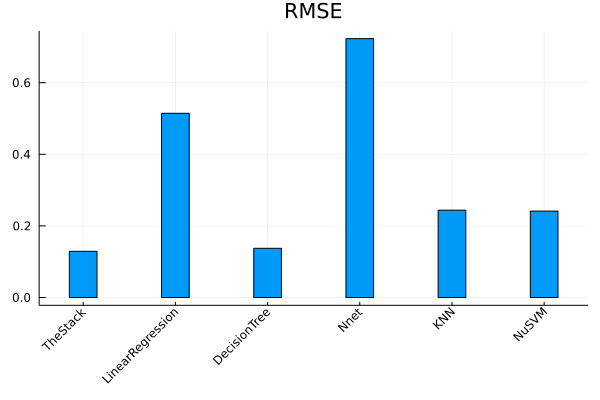

In [10]:
bar(modelnames, measurements, title="RMSE", xrotation=45, bar_width = 0.3, legend=false)

# Demonstrating some properties of TMLE: ATE

In [11]:
function build_estimator(estim_type, cond_target_estim, cond_treat_estim, problem)
    family = nothing
    if occursin("categorical", string(problem))
        family = Bernoulli()
    elseif occursin("continuous", string(problem))
        family = Normal()
    else
        error("Not recognised problem")
    end
    return estim_type(cond_target_estim, cond_treat_estim, family)
end

function asymptotics(estim_type, cond_target_estim, cond_treat_estim, problem, ns;v=0, rng=StableRNG(123))
    estimator = build_estimator(estim_type, 
                                cond_target_estim, 
                                cond_treat_estim, 
                                problem)
    estimates = []
    std_errors = []
    truth = []
    for n in ns
        T, W, y, ATE = problem(rng;n=n)
        fitresult, cache, report = MLJ.fit(estimator, v, T, W, y)
        push!(estimates, fitresult.estimate)
        push!(std_errors, fitresult.stderror)
        push!(truth, ATE)
    end
    estimates, std_errors, truth
end

function multirun(estim_type, cond_target_estim, cond_treat_estim, problem;
                    v=0, nruns=1000, pbsize=1000, rng=StableRNG(123))
    estimator = build_estimator(estim_type, 
                                cond_target_estim, 
                                cond_treat_estim, 
                                problem)
    estimates = []
    ATE = 0
    for i in 1:nruns
        T, W, y, ATE = problem(rng;n=pbsize)
        fitresult, cache, report = MLJ.fit(estimator, v, T, W, y)
        push!(estimates, fitresult.estimate)
    end
    estimates, ATE
end

multirun (generic function with 1 method)

## Double Robustness of the ATE estimator

In [12]:
Ns = convert(Vector{Int}, [1e2, 3e2, 7e2, 1e3, 3e3, 7e3, 1e4, 3e4, 7e4, 1e5]);

In [13]:
cat_estimates₁, cat_stderrors₁, cat_truth₁ = asymptotics(ATEEstimator, ConstantClassifier(), ConstantClassifier(), categorical_problem, Ns;v=0)
cat_estimates₂, cat_stderrors₂, cat_truth₂ = asymptotics(ATEEstimator, LogisticClassifier(), ConstantClassifier(), categorical_problem, Ns;v=0)
cat_estimates₃, cat_stderrors₃, cat_truth₃ = asymptotics(ATEEstimator, ConstantClassifier(), LogisticClassifier(), categorical_problem, Ns;v=0)
cat_estimates₄, cat_stderrors₄, cat_truth₄ = asymptotics(ATEEstimator, LogisticClassifier(), LogisticClassifier(), categorical_problem, Ns;v=0);

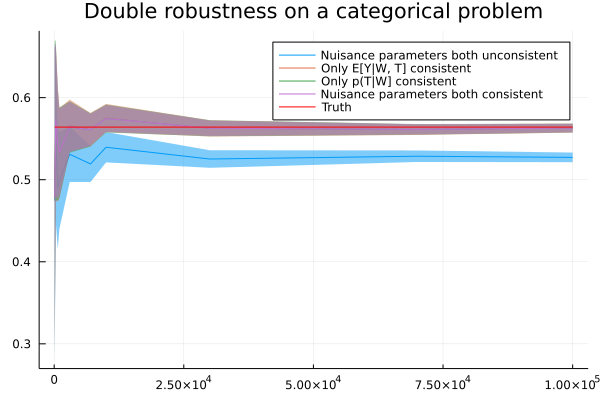

In [61]:
plot(Ns, cat_estimates₁, ribbon=1.98*cat_stderrors₁, 
    label="Nuisance parameters both unconsistent", 
    title="Double robustness on a categorical problem",
    legend=:best)
plot!(Ns, cat_estimates₂, ribbon=1.98*cat_stderrors₂, label="Only E[Y|W, T] consistent")
plot!(Ns, cat_estimates₃, ribbon=1.98*cat_stderrors₃, label="Only p(T|W] consistent")
plot!(Ns, cat_estimates₄, ribbon=1.98*cat_stderrors₄, label="Nuisance parameters both consistent")
plot!(Ns, cat_truth₁, label="Truth", color="red", )

In [124]:
cat_estimates₄[end] - 1.98cat_stderrors₄[end], cat_estimates₄[end] + 1.98cat_stderrors₄[end], cat_truth₁[end]

(0.5576836841354834, 0.5681182380412947, 0.564071197672251)

In [15]:
cont_estimates₁, cont_stderrors₁, cont_truth₁ = asymptotics(ATEEstimator, MLJ.DeterministicConstantRegressor(), ConstantClassifier(), continuous_problem, Ns;v=0)
cont_estimates₂, cont_stderrors₂, cont_truth₂ = asymptotics(ATEEstimator, LinearRegressor(), ConstantClassifier(), continuous_problem, Ns;v=0)
cont_estimates₃, cont_stderrors₃, cont_truth₃ = asymptotics(ATEEstimator, MLJ.DeterministicConstantRegressor(), LogisticClassifier(), continuous_problem, Ns;v=0)
cont_estimates₄, cont_stderrors₄, cont_truth₄ = asymptotics(ATEEstimator, LinearRegressor(), LogisticClassifier(), continuous_problem, Ns;v=0);

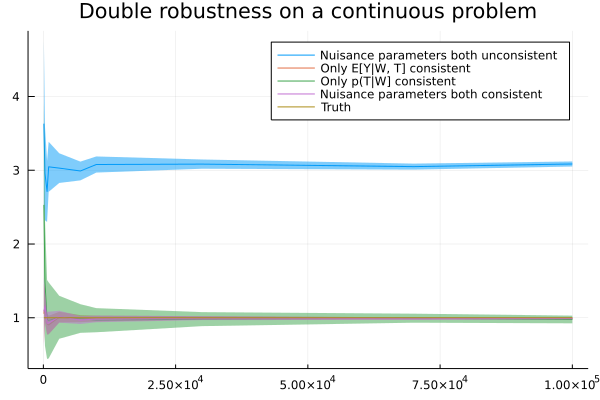

In [16]:
plot(Ns, cont_estimates₁, ribbon=1.98*cont_stderrors₁, 
    label="Nuisance parameters both unconsistent", 
    title="Double robustness on a continuous problem",
    legend=:best)
plot!(Ns, cont_estimates₂, ribbon=1.98*cont_stderrors₂, label="Only E[Y|W, T] consistent")
plot!(Ns, cont_estimates₃, ribbon=1.98*cont_stderrors₃, label="Only p(T|W] consistent")
plot!(Ns, cont_estimates₄, ribbon=1.98*cont_stderrors₄, label="Nuisance parameters both consistent")
plot!(Ns, cont_truth₁, label="Truth")

## Normality of the ATE estimator

In [17]:
estimates, truth = multirun(ATEEstimator, 
                            LogisticClassifier(), 
                            LogisticClassifier(), 
                            categorical_problem;
                            v=0, nruns=10000, pbsize=1000);

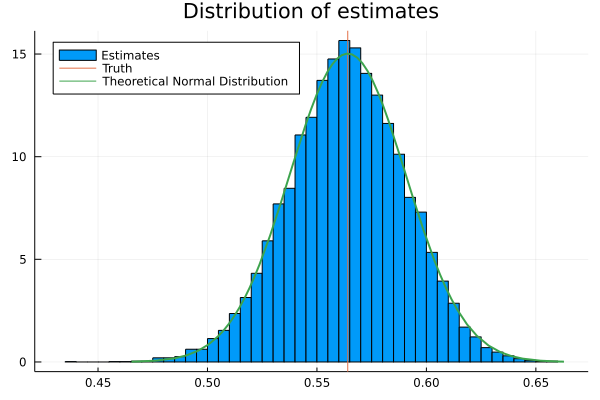

In [18]:
histogram(estimates, 
    title="Distribution of estimates", 
    label="Estimates",
    normalize=true,
    legend=:topleft)
plot!([truth];
    seriestype = :vline, 
    label="Truth")
plot!(Normal(truth, std(estimates)), lw = 2, 
    label="Theoretical Normal Distribution")

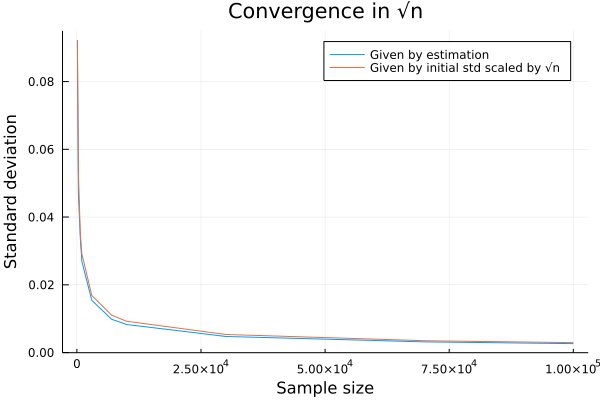

In [19]:
ratios = [sqrt(Ns[1]/n) for n in Ns]
scaled = [cat_stderrors₄[1]*r for r in ratios]
plot(Ns, cat_stderrors₄, 
        label="Given by estimation", 
        title="Convergence in √n",
        xlabel="Sample size",
        ylabel="Standard deviation")
plot!(Ns, scaled, label="Given by initial std scaled by √n")

## Comparison with the initial estimator

In [20]:
mutable struct NaiveATEEstimator
    target_cond_expectation_estimator::MLJ.Supervised
end

function MLJ.fit(tmle::NaiveATEEstimator, 
                 verbosity::Int, 
                 t::CategoricalVector{Bool}, 
                 W, 
                 y::Union{CategoricalVector{Bool}, Vector{<:Real}})
    n = nrows(y)

    # Fit Encoding of the treatment variable
    T = (t=float(t),)
    W = Tables.columntable(W)

    # Input checks and reformating
    X = merge(T, W)
    
    # Initial estimate of E[Y|A, W]
    target_expectation_mach = machine(tmle.target_cond_expectation_estimator, X, y)
    fit!(target_expectation_mach, verbosity=verbosity)


    # Compute the final estimate tmleATE = 1/n ∑ Fluctuator(t=1, W=w) - Fluctuator(t=0, W=w)
    Ttrue = (t=ones(n),)
    Xtrue = merge(Ttrue, W)
    Qtrue = MLJ.predict(target_expectation_mach, Xtrue).prob_given_ref[2]
    
    Tfalse = (t=zeros(n),)
    Xfalse = merge(Tfalse, W)
    Qfalse = MLJ.predict(target_expectation_mach, Xfalse).prob_given_ref[2]

    estimate = mean(Qtrue-Qfalse)
    

    fitresult = (
        estimate=estimate,
        target_expectation_mach=target_expectation_mach,
        )

    cache = nothing
    report = nothing
    return fitresult, cache, report

end

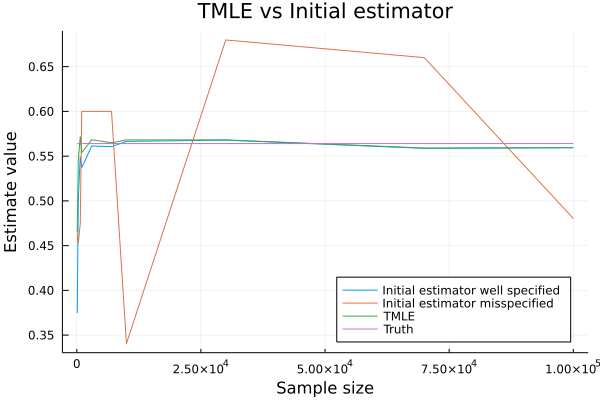

In [21]:
naive_estimator = NaiveATEEstimator(LogisticClassifier())
naive_estimator_mis = NaiveATEEstimator(KNNClassifier())
tmle_estimator = ATEEstimator(ConstantClassifier(), LogisticClassifier(), Bernoulli())

naive_estimates = []
naive_estimates_mis = []
tmle_estimates = []
truth = []

for n in Ns
    rng = StableRNG(n)
    T, W, y, ATE = categorical_problem(rng;n=n)
    
    fitresult, cache, report = MLJ.fit(naive_estimator, 0, T, W, y)
    push!(naive_estimates, fitresult.estimate)
    
    fitresult, cache, report = MLJ.fit(naive_estimator_mis, 0, T, W, y)
    push!(naive_estimates_mis, fitresult.estimate)
    
    fitresult, cache, report = MLJ.fit(tmle_estimator, 0, T, W, y)
    push!(tmle_estimates, fitresult.estimate)
    
    push!(truth, ATE)
end
plot(Ns, naive_estimates, xlabel="Sample size", ylabel="Estimate value", label="Initial estimator well specified")
plot!(Ns, naive_estimates_mis, label="Initial estimator misspecified")
plot!(Ns, tmle_estimates, label="TMLE", title="TMLE vs Initial estimator")
plot!(Ns, truth, label="Truth", legend=:bottomright)

# Demonstrating some properties of TMLE: Interaction ATE

Defining some more models

In [69]:
mutable struct InteractionTransformer <: Static end

function MLJ.transform(a::InteractionTransformer, _, X)
    Xmatrix = MLJ.matrix(X)
    nrows, ncols = size(Xmatrix)
    ninter = Int(ncols*(ncols-1)/2)
    Xinteracts = Matrix{Float64}(undef, nrows, ninter)
    i = 0
    for col₁ in 1:(ncols-1)
        for col₂ in (col₁+1):ncols
            i += 1
            Xinteracts[:, i] = Xmatrix[:, col₁] .* Xmatrix[:, col₂]
        end
    end
    return MLJ.table(hcat(Xmatrix, Xinteracts))
end


mutable struct FixedMultinomialRegression <: Probabilistic
    coefs
    classes
end

FixedMultinomialRegression() = FixedMultinomialRegression([1 2 -3 -2; 
                                                           -2 4 6 0 ;
                                                            3 -1 -4 2], 
                                                            categorical([1, 2, 3, 4]))

function MLJ.fit(m::FixedMultinomialRegression, v::Int, X, y)
    return nothing,nothing, nothing
end

function MLJ.predict(m::FixedMultinomialRegression, fitresult, Xnew)
    Xmat = MLJ.matrix(Xnew)
    softmax = exp.(Xmat*m.coefs) ./ sum(exp.(Xmat*m.coefs), dims=2)
    return MLJ.UnivariateFinite(m.classes, softmax)
end

interaction_lr_cont = @pipeline InteractionTransformer() LinearRegressor(fit_intercept=false);
interaction_lr_cat = @pipeline InteractionTransformer() LogisticClassifier(fit_intercept=false);

In [66]:
inter_estimates₁, inter_stderrors₁, inter_truth₁ = asymptotics(InteractionATEEstimator, MLJ.DeterministicConstantRegressor(), ConstantClassifier(), interaction_continuous_problem, Ns;v=0, rng=StableRNG(134))
inter_estimates₂, inter_stderrors₂, inter_truth₂ = asymptotics(InteractionATEEstimator, interaction_lr_cont, ConstantClassifier(), interaction_continuous_problem, Ns;v=0, rng=StableRNG(134))
inter_estimates₃, inter_stderrors₃, inter_truth₃ = asymptotics(InteractionATEEstimator, MLJ.DeterministicConstantRegressor(), FixedMultinomialRegression(), interaction_continuous_problem, Ns;v=0, rng=StableRNG(134))
inter_estimates₄, inter_stderrors₄, inter_truth₄ = asymptotics(InteractionATEEstimator, interaction_lr_cont, FixedMultinomialRegression(), interaction_continuous_problem, Ns;v=0, rng=StableRNG(134));

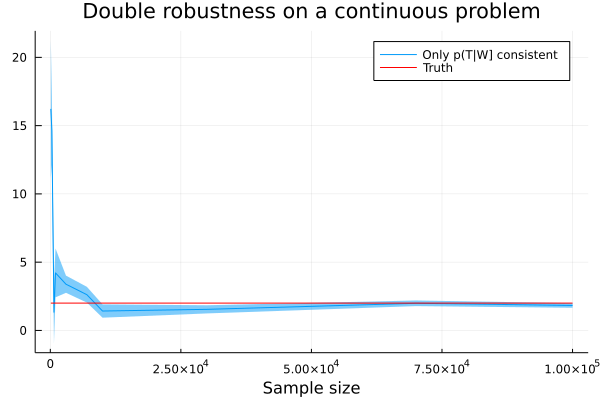

In [67]:
#plot(Ns, inter_estimates₁, ribbon=1.98*inter_stderrors₁, 
#    label="Nuisance parameters both unconsistent", 
#    title="Double robustness on a continuous problem",
#    legend=:topright)
#plot(Ns, inter_estimates₂, ribbon=1.98*inter_stderrors₂, label="Only E[Y|W, T] consistent")
plot(Ns, inter_estimates₃, ribbon=1.98*inter_stderrors₃, label="Only p(T|W] consistent")
#plot!(Ns, inter_estimates₄, ribbon=1.98*inter_stderrors₄, label="Nuisance parameters both consistent")
plot!(Ns, inter_truth₁, 
        label="Truth",  
        color="red", 
        xlabel="Sample size", 
        legend=:best, 
        title="Double robustness on a continuous problem")

In [70]:
inter_estimates_cat₁, inter_stderrors_cat₁, inter_truth_cat₁ = asymptotics(InteractionATEEstimator, ConstantClassifier(), ConstantClassifier(), interaction_categorical_problem, Ns;v=0, rng=StableRNG(134))
inter_estimates_cat₂, inter_stderrors_cat₂, inter_truth_cat₂ = asymptotics(InteractionATEEstimator, interaction_lr_cat, ConstantClassifier(), interaction_categorical_problem, Ns;v=0, rng=StableRNG(134))
inter_estimates_cat₃, inter_stderrors_cat₃, inter_truth_cat₃ = asymptotics(InteractionATEEstimator, ConstantClassifier(), FixedMultinomialRegression(), interaction_categorical_problem, Ns;v=0, rng=StableRNG(134))
inter_estimates_cat₄, inter_stderrors_cat₄, inter_truth_cat₄ = asymptotics(InteractionATEEstimator, interaction_lr_cat, FixedMultinomialRegression(), interaction_categorical_problem, Ns;v=0, rng=StableRNG(134));

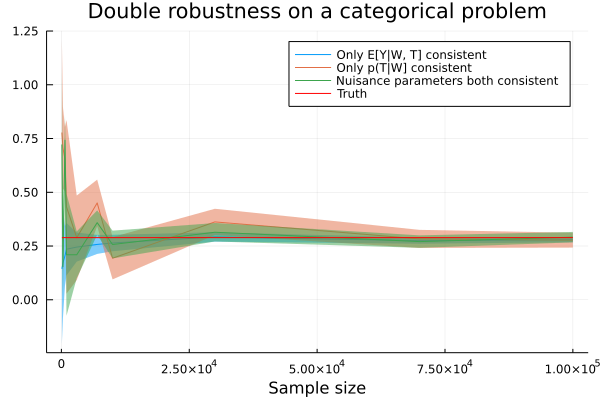

In [74]:
#plot(Ns, inter_estimates_cat₁, ribbon=1.98*inter_stderrors_cat₁, 
#    label="Nuisance parameters both unconsistent", 
#    title="Double robustness on a continuous problem",
#    legend=:topright)
plot(Ns, inter_estimates_cat₂, ribbon=1.98*inter_stderrors_cat₂, label="Only E[Y|W, T] consistent")
plot!(Ns, inter_estimates_cat₃, ribbon=1.98*inter_stderrors_cat₃, label="Only p(T|W] consistent")
plot!(Ns, inter_estimates_cat₄, ribbon=1.98*inter_stderrors_cat₄, label="Nuisance parameters both consistent")
plot!(Ns, inter_truth_cat₁, 
        label="Truth",  
        color="red", 
        xlabel="Sample size", 
        legend=:best, 
        title="Double robustness on a categorical problem")

In [125]:
inter_estimates_cat₄[end] - 1.98inter_stderrors_cat₄[end], inter_estimates_cat₄[end] + 1.98inter_stderrors_cat₄[end], inter_truth_cat₁[end]

(0.26700713244949015, 0.31555495970258196, 0.2891433358503781)

## Normality of the ATE estimator categorical problem

In [113]:
inter_estimates, inter_truth = multirun(InteractionATEEstimator, 
                            interaction_lr_cat, 
                            LogisticClassifier(fit_intercept=false), 
                            interaction_categorical_problem;
                            v=0, nruns=10000, pbsize=10000);

In [118]:
inter_estimates_small, inter_truth_small = multirun(InteractionATEEstimator, 
                            interaction_lr_cat, 
                            ConstantClassifier(), 
                            interaction_categorical_problem;
                            v=0, nruns=10000, pbsize=1000);

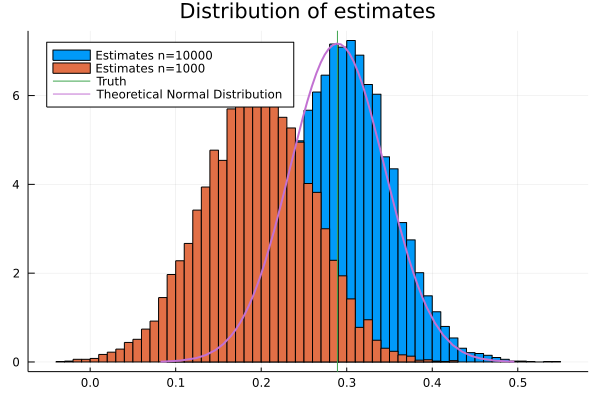

In [119]:
histogram(inter_estimates, 
    title="Distribution of estimates", 
    label="Estimates n=10000",
    normalize=true,
    legend=:topleft)
histogram!(inter_estimates_small, 
        label="Estimates n=1000",
        normalize=true)
plot!([inter_truth];
    seriestype = :vline, 
    label="Truth")
plot!(Normal(inter_truth, std(inter_estimates)), lw = 2, 
    label="Theoretical Normal Distribution")

## Normality of the ATE estimator continuous problem

In [92]:
inter_estimates, inter_truth = multirun(InteractionATEEstimator, 
                            interaction_lr_cont, 
                            LogisticClassifier(), 
                            interaction_continuous_problem;
                            v=0, nruns=10000, pbsize=10000);

In [108]:
inter_estimates_small, inter_truth_small = multirun(InteractionATEEstimator, 
                            MLJ.DeterministicConstantRegressor(), 
                            LogisticClassifier(fit_intercept=false), 
                            interaction_continuous_problem;
                            v=0, nruns=10000, pbsize=1000);

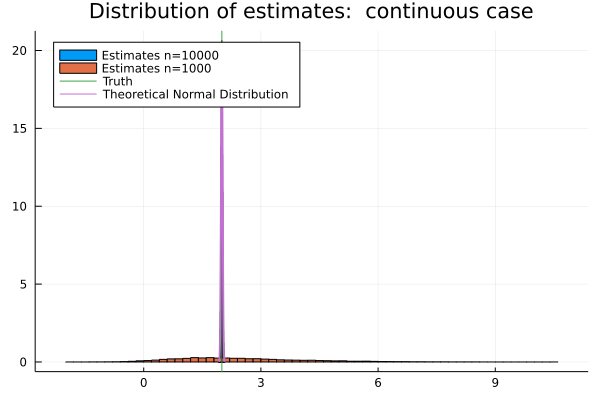

In [109]:
histogram(inter_estimates, 
    title="Distribution of estimates:  continuous case", 
    label="Estimates n=10000",
    normalize=true,
    legend=:topleft)
histogram!(inter_estimates_small, 
        label="Estimates n=1000",
        normalize=true)
plot!([inter_truth];
    seriestype = :vline, 
    label="Truth")
plot!(Normal(inter_truth, std(inter_estimates)), lw = 2, 
    label="Theoretical Normal Distribution")

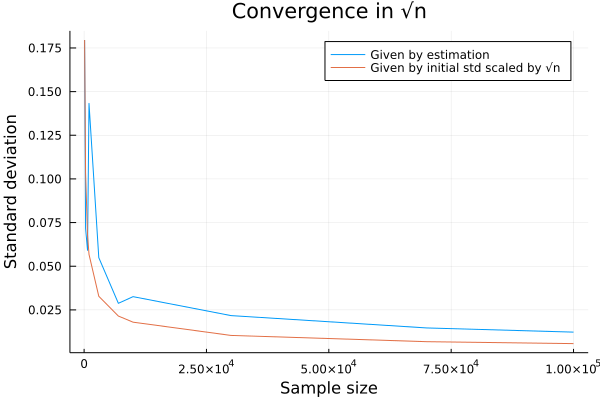

In [106]:
ratios = [sqrt(Ns[1]/n) for n in Ns]
scaled = [inter_stderrors_cat₄[1]*r for r in ratios]
plot(Ns, inter_stderrors_cat₄, 
        label="Given by estimation", 
        title="Convergence in √n",
        xlabel="Sample size",
        ylabel="Standard deviation")
plot!(Ns, scaled, label="Given by initial std scaled by √n")

## Comparison with the initial estimator

Let's define the naive inference strategy

In [29]:
mutable struct NaiveInteractionATEEstimator 
    target_cond_expectation_estimator::MLJ.Supervised
end


function MLJ.fit(tmle::NaiveInteractionATEEstimator, 
                 verbosity::Int, 
                 T,
                 W, 
                 y::Union{CategoricalVector{Bool}, Vector{<:Real}})
    n = nrows(y)

    # Input checks and reformating
    T = NamedTuple{keys(T)}([float(x) for x in T])
    W = Tables.columntable(W)
    X = merge(T, W)
    
    # Initial estimate of E[Y|A, W]
    target_expectation_mach = machine(tmle.target_cond_expectation_estimator, X, y)
    fit!(target_expectation_mach, verbosity=verbosity)


    # Compute the final estimate 
    # InteractionATE = 1/n ∑ [ Fluctuator(t₁=1, t₂=1, W=w) - Fluctuator(t₁=1, t₂=0, W=w)
    #                        - Fluctuator(t₁=0, t₂=1, W=w) + Fluctuator(t₁=0, t₂=0, W=w)]
    counterfactual_treatments = [(true, true, 1), 
                                (true, false, -1), 
                                (false, true, -1), 
                                (false, false, 1)]
    fluct = zeros(n)
    features = Tables.schema(T).names
    for (t₁, t₂, sign) in counterfactual_treatments
        counterfactualT = NamedTuple{features}([
                            categorical(repeat([t₁], n), levels=[true, false]), 
                            categorical(repeat([t₂], n), levels=[true, false])
        ])
        counterfactualT = NamedTuple{keys(T)}([float(x) for x in counterfactualT])
        Xcounterfactual = merge(counterfactualT, W)
        fluct .+=  sign * MLJ.predict(target_expectation_mach, Xcounterfactual)
    end

    estimate = mean(fluct)

    fitresult = (
    estimate=estimate,
    target_expectation_mach=target_expectation_mach,
    )

    cache = nothing
    report = nothing
    return fitresult, cache, report
end

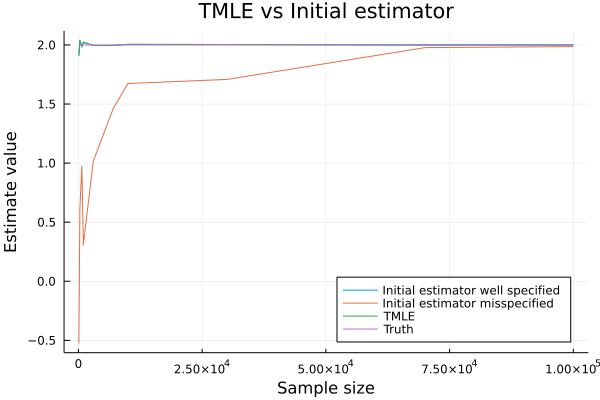

In [30]:
naive_estimator = NaiveInteractionATEEstimator(interaction_lr)
naive_estimator_mis = NaiveInteractionATEEstimator(KNNRegressor())
tmle_estimator = InteractionATEEstimator(interaction_lr, ConstantClassifier(), Normal())

naive_estimates = []
naive_estimates_mis = []
tmle_estimates = []
truth = []
rng = StableRNG(123)
for n in Ns
    T, W, y, ATE = interaction_continuous_problem(rng;n=n)
    
    fitresult, cache, report = MLJ.fit(naive_estimator, 0, T, W, y)
    push!(naive_estimates, fitresult.estimate)
    
    fitresult, cache, report = MLJ.fit(naive_estimator_mis, 0, T, W, y)
    push!(naive_estimates_mis, fitresult.estimate)
    
    fitresult, cache, report = MLJ.fit(tmle_estimator, 0, T, W, y)
    push!(tmle_estimates, fitresult.estimate)
    
    push!(truth, ATE)
end
plot(Ns, naive_estimates, xlabel="Sample size", ylabel="Estimate value", label="Initial estimator well specified")
plot!(Ns, naive_estimates_mis, label="Initial estimator misspecified")
plot!(Ns, tmle_estimates, label="TMLE", title="TMLE vs Initial estimator")
plot!(Ns, truth, label="Truth", legend=:bottomright)

# Interlude on the softmax

In [31]:
rng = StableRNG(123)

p = 3
c = 4
θ = [ 1 2 -3 4;
     2 -3 2 -2;
     -1 3 -1 2]
fitted_params = []
for n in Ns
    # Data sampling
    X = rand(rng, n, p)
    M = exp.(X*θ)
    mu = M  ./ sum(M, dims=2)
    y = categorical([sample(rng, [1, 2, 3, 4], Weights(mu[i, :])) for i in 1:n])

    # Fitting
    mach = machine(LogisticClassifier(fit_intercept=false, lambda=0, gamma=0), MLJ.table(X), y)
    fit!(mach; verbosity=0)
    push!(fitted_params, reshape(mach.fitresult[1], p, c))
end

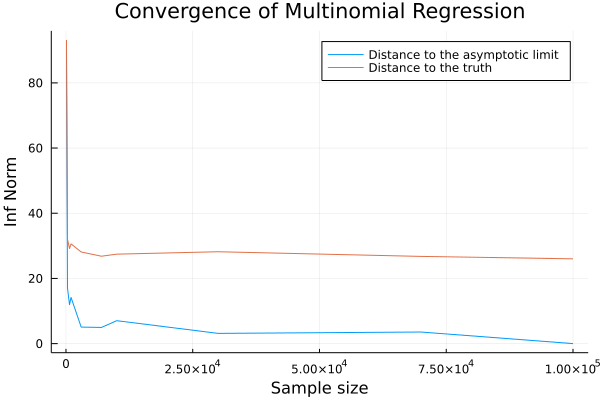

In [32]:
distance(θ₁, θ₂) = maximum(abs.(θ₁ - θ₂) / maximum(θ₂)) * 100

distances_to_asymptotic = [distance(p, fitted_params[end]) for p in fitted_params]

distances_to_truth = [distance(p, θ) for p in fitted_params]

plot(Ns, distances_to_asymptotic, 
    label="Distance to the asymptotic limit", 
    xlabel="Sample size", 
    ylabel="Inf Norm",
    title="Convergence of Multinomial Regression")
plot!(Ns, distances_to_truth, label="Distance to the truth")

In [33]:
shift = mean(fitted_params[end] - θ, dims=2)

3×1 Matrix{Float64}:
 -0.9999999999999988
  0.25000000000000006
 -0.75

# Quality of estimators illustration

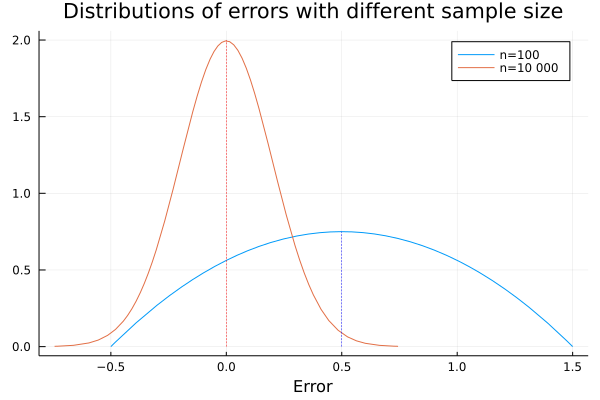

In [34]:
plot(Epanechnikov(0.5, 1), title="Distributions of errors with different sample size", xlabel="Error", label="n=100")
plot!(Normal(0, 0.2), label="n=10 000")
plot!([0, 0], [0, 2]; seriestype = :path, color="red", linewidth=0.5, linestyle=:dash, label=:none)
plot!([0.5, 0.5], [0, 0.75]; seriestype = :path, color="blue", linewidth=0.5, linestyle=:dash, label=:none)